In [1]:
import pandas as pd
import numpy as np 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


/opt/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
animeDf = pd.read_csv('anime.csv')

In [3]:
def getAnimeName(id):
	name = animeDf[animeDf.MAL_ID == id]['English name'].values[0]
	if name is np.nan or name == "Unknown":
		name = animeDf[animeDf.MAL_ID == id]['Name'].values[0]
	return name
animeDf['eng_name'] = animeDf.MAL_ID.apply(lambda x :getAnimeName(x) )

In [4]:

animeDf = animeDf[['Score','Ranked','Genres','eng_name','Type','Episodes','Source','Studios']]
animeDf = animeDf[animeDf.Score != 'Unknown']
animeDf = animeDf[animeDf.Ranked!= 'Unknown']
animeDf = animeDf[animeDf.Episodes != 'Unknown']

In [5]:
animeDf.Score = animeDf.Score.apply(lambda x: float(x))
animeDf.Ranked = animeDf.Ranked.apply(lambda x: float(x))
animeDf.Episodes = animeDf.Episodes.apply(lambda x: int(x))

In [6]:
animeDf

,Score,Ranked,Genres,eng_name,Type,Episodes,Source,Studios
0,8.78,28.0,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,TV,26,Original,Sunrise
1,8.39,159.0,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,Movie,1,Original,Bones
2,8.24,266.0,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,TV,26,Manga,Madhouse
3,7.27,2481.0,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,TV,26,Original,Sunrise
4,6.98,3710.0,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,TV,52,Manga,Toei Animation
...,...,...,...,...,...,...,...,...
17504,6.59,5461.0,Comedy,Kimetsu Gakuen: Valentine-hen,ONA,4,Original,Unknown
17505,7.52,1517.0,"Music, Romance",Heikousen,Music,1,Original,"10Gauge, Studio DURIAN"
17512,6.83,4382.0,"Slice of Life, Comedy",Cooking with Valkyries Spring Festival Special,Special,1,Game,Unknown
17513,4.81,10760.0,"Mystery, Psychological, Supernatural, Thriller...",The Promised Neverland Season 2 Episode 5.5,Special,1,Manga,CloverWorks


In [7]:
l = animeDf.Genres.to_numpy()
l= [x.split(',') for x in l]
uniqueGenres = []
for x in l:
	for y in x:
		y.strip()
		if y not in uniqueGenres:
			uniqueGenres.append(y)
uniqueGenres = np.array(uniqueGenres)
uniqueGenres = [x.strip() for x in uniqueGenres]
uniqueGenres = np.unique(uniqueGenres)

In [8]:
genreCol = animeDf.Genres
index = animeDf.index
t = []
for x in genreCol:
	ohe = np.zeros(len(uniqueGenres))
	genres = x.split(',')
	genres = [y.strip() for y in genres]
	for y in genres:
		index = np.where(uniqueGenres == y)
		ohe[index[0][0]] = 1
	t.append(ohe)
#t = pd.Series(t, name='Genres', index=animeDf.index)
genresDf = pd.DataFrame(t, columns=uniqueGenres, index=animeDf.index)

In [9]:
genresDf.drop('Unknown', inplace=True, axis=1)
genresDf.head()

,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,...,Shoujo Ai,Shounen,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire
0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [10]:
ndf = animeDf.copy()
ndf.drop(columns='Genres',inplace=True)
ndf = ndf.join(genresDf)
ndf.drop(columns=['Ranked','eng_name'], inplace=True)

In [11]:
train, val, test = np.split(ndf.sample(frac=1), [int(0.8*len(ndf)), int(0.9*len(ndf))])

In [12]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('Score')
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  labels = [float(x) for x in labels]
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [13]:
train_ds = df_to_dataset(train, batch_size=5)

/var/folders/x6/lvkjlh4x45bdhl62l88rhwzm0000gn/T/ipykernel_57328/1533925542.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
2022-08-22 15:14:03.932221: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [35]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of types:', train_features['Type'])
print('A batch of targets:', label_batch )

Every feature: ['Score', 'Type', 'Episodes', 'Source', 'Studios', 'Action', 'Adventure', 'Cars', 'Comedy', 'Dementia', 'Demons', 'Drama', 'Ecchi', 'Fantasy', 'Game', 'Harem', 'Historical', 'Horror', 'Josei', 'Kids', 'Magic', 'Martial Arts', 'Mecha', 'Military', 'Music', 'Mystery', 'Parody', 'Police', 'Psychological', 'Romance', 'Samurai', 'School', 'Sci-Fi', 'Seinen', 'Shoujo', 'Shoujo Ai', 'Shounen', 'Shounen Ai', 'Slice of Life', 'Space', 'Sports', 'Super Power', 'Supernatural', 'Thriller', 'Vampire']
A batch of types: tf.Tensor(
[[b'TV']
 [b'TV']
 [b'Movie']
 [b'Special']
 [b'Movie']
 [b'OVA']
 [b'OVA']
 [b'Special']
 [b'Movie']
 [b'OVA']
 [b'TV']
 [b'ONA']
 [b'Movie']
 [b'ONA']
 [b'OVA']
 [b'TV']
 [b'Movie']
 [b'TV']
 [b'TV']
 [b'OVA']
 [b'TV']
 [b'Music']
 [b'Special']
 [b'TV']
 [b'Movie']
 [b'TV']
 [b'ONA']
 [b'TV']
 [b'Movie']
 [b'Movie']
 [b'TV']
 [b'Music']
 [b'OVA']
 [b'TV']
 [b'TV']
 [b'TV']
 [b'Special']
 [b'TV']
 [b'Movie']
 [b'OVA']
 [b'OVA']
 [b'TV']
 [b'Special']
 [b'OV

In [15]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [16]:
numEpisodes = train_features['Episodes']
layer = get_normalization_layer('Episodes',train_ds)
layer(numEpisodes)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[-0.2539499 ],
       [-0.23182273],
       [-0.2539499 ],
       [-0.2539499 ],
       [-0.2539499 ]], dtype=float32)>

In [17]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

In [18]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

/var/folders/x6/lvkjlh4x45bdhl62l88rhwzm0000gn/T/ipykernel_57328/1533925542.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


In [19]:

g = ndf.columns[5:]
g = g.to_list()
g.append('Episodes')
print(g)

['Action', 'Adventure', 'Cars', 'Comedy', 'Dementia', 'Demons', 'Drama', 'Ecchi', 'Fantasy', 'Game', 'Harem', 'Historical', 'Horror', 'Josei', 'Kids', 'Magic', 'Martial Arts', 'Mecha', 'Military', 'Music', 'Mystery', 'Parody', 'Police', 'Psychological', 'Romance', 'Samurai', 'School', 'Sci-Fi', 'Seinen', 'Shoujo', 'Shoujo Ai', 'Shounen', 'Shounen Ai', 'Slice of Life', 'Space', 'Sports', 'Super Power', 'Supernatural', 'Thriller', 'Vampire', 'Episodes']


In [20]:

all_inputs = []
encoded_features = []
# Numerical features.
for header in g:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

In [21]:
category_cols = ['Type','Source','Studios']
for header in category_cols:
	category_col = tf.keras.Input(shape=(1,), name=header)
	encoding_layer = get_category_encoding_layer(header, train_ds, 'string')
	encoded_category_col = encoding_layer(category_col)
	all_inputs.append(category_col)
	encoded_features.append(encoded_category_col)

In [29]:
encoded_features[:-3]

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_1')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_2')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_3')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_4')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_5')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_6')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_7')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_8')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_9')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_10')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_11')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalizat

In [30]:
all_features = tf.keras.layers.concatenate(encoded_features[:-3])
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

In [31]:
model.compile(optimizer='Adam',loss='mae',metrics=['accuracy'])

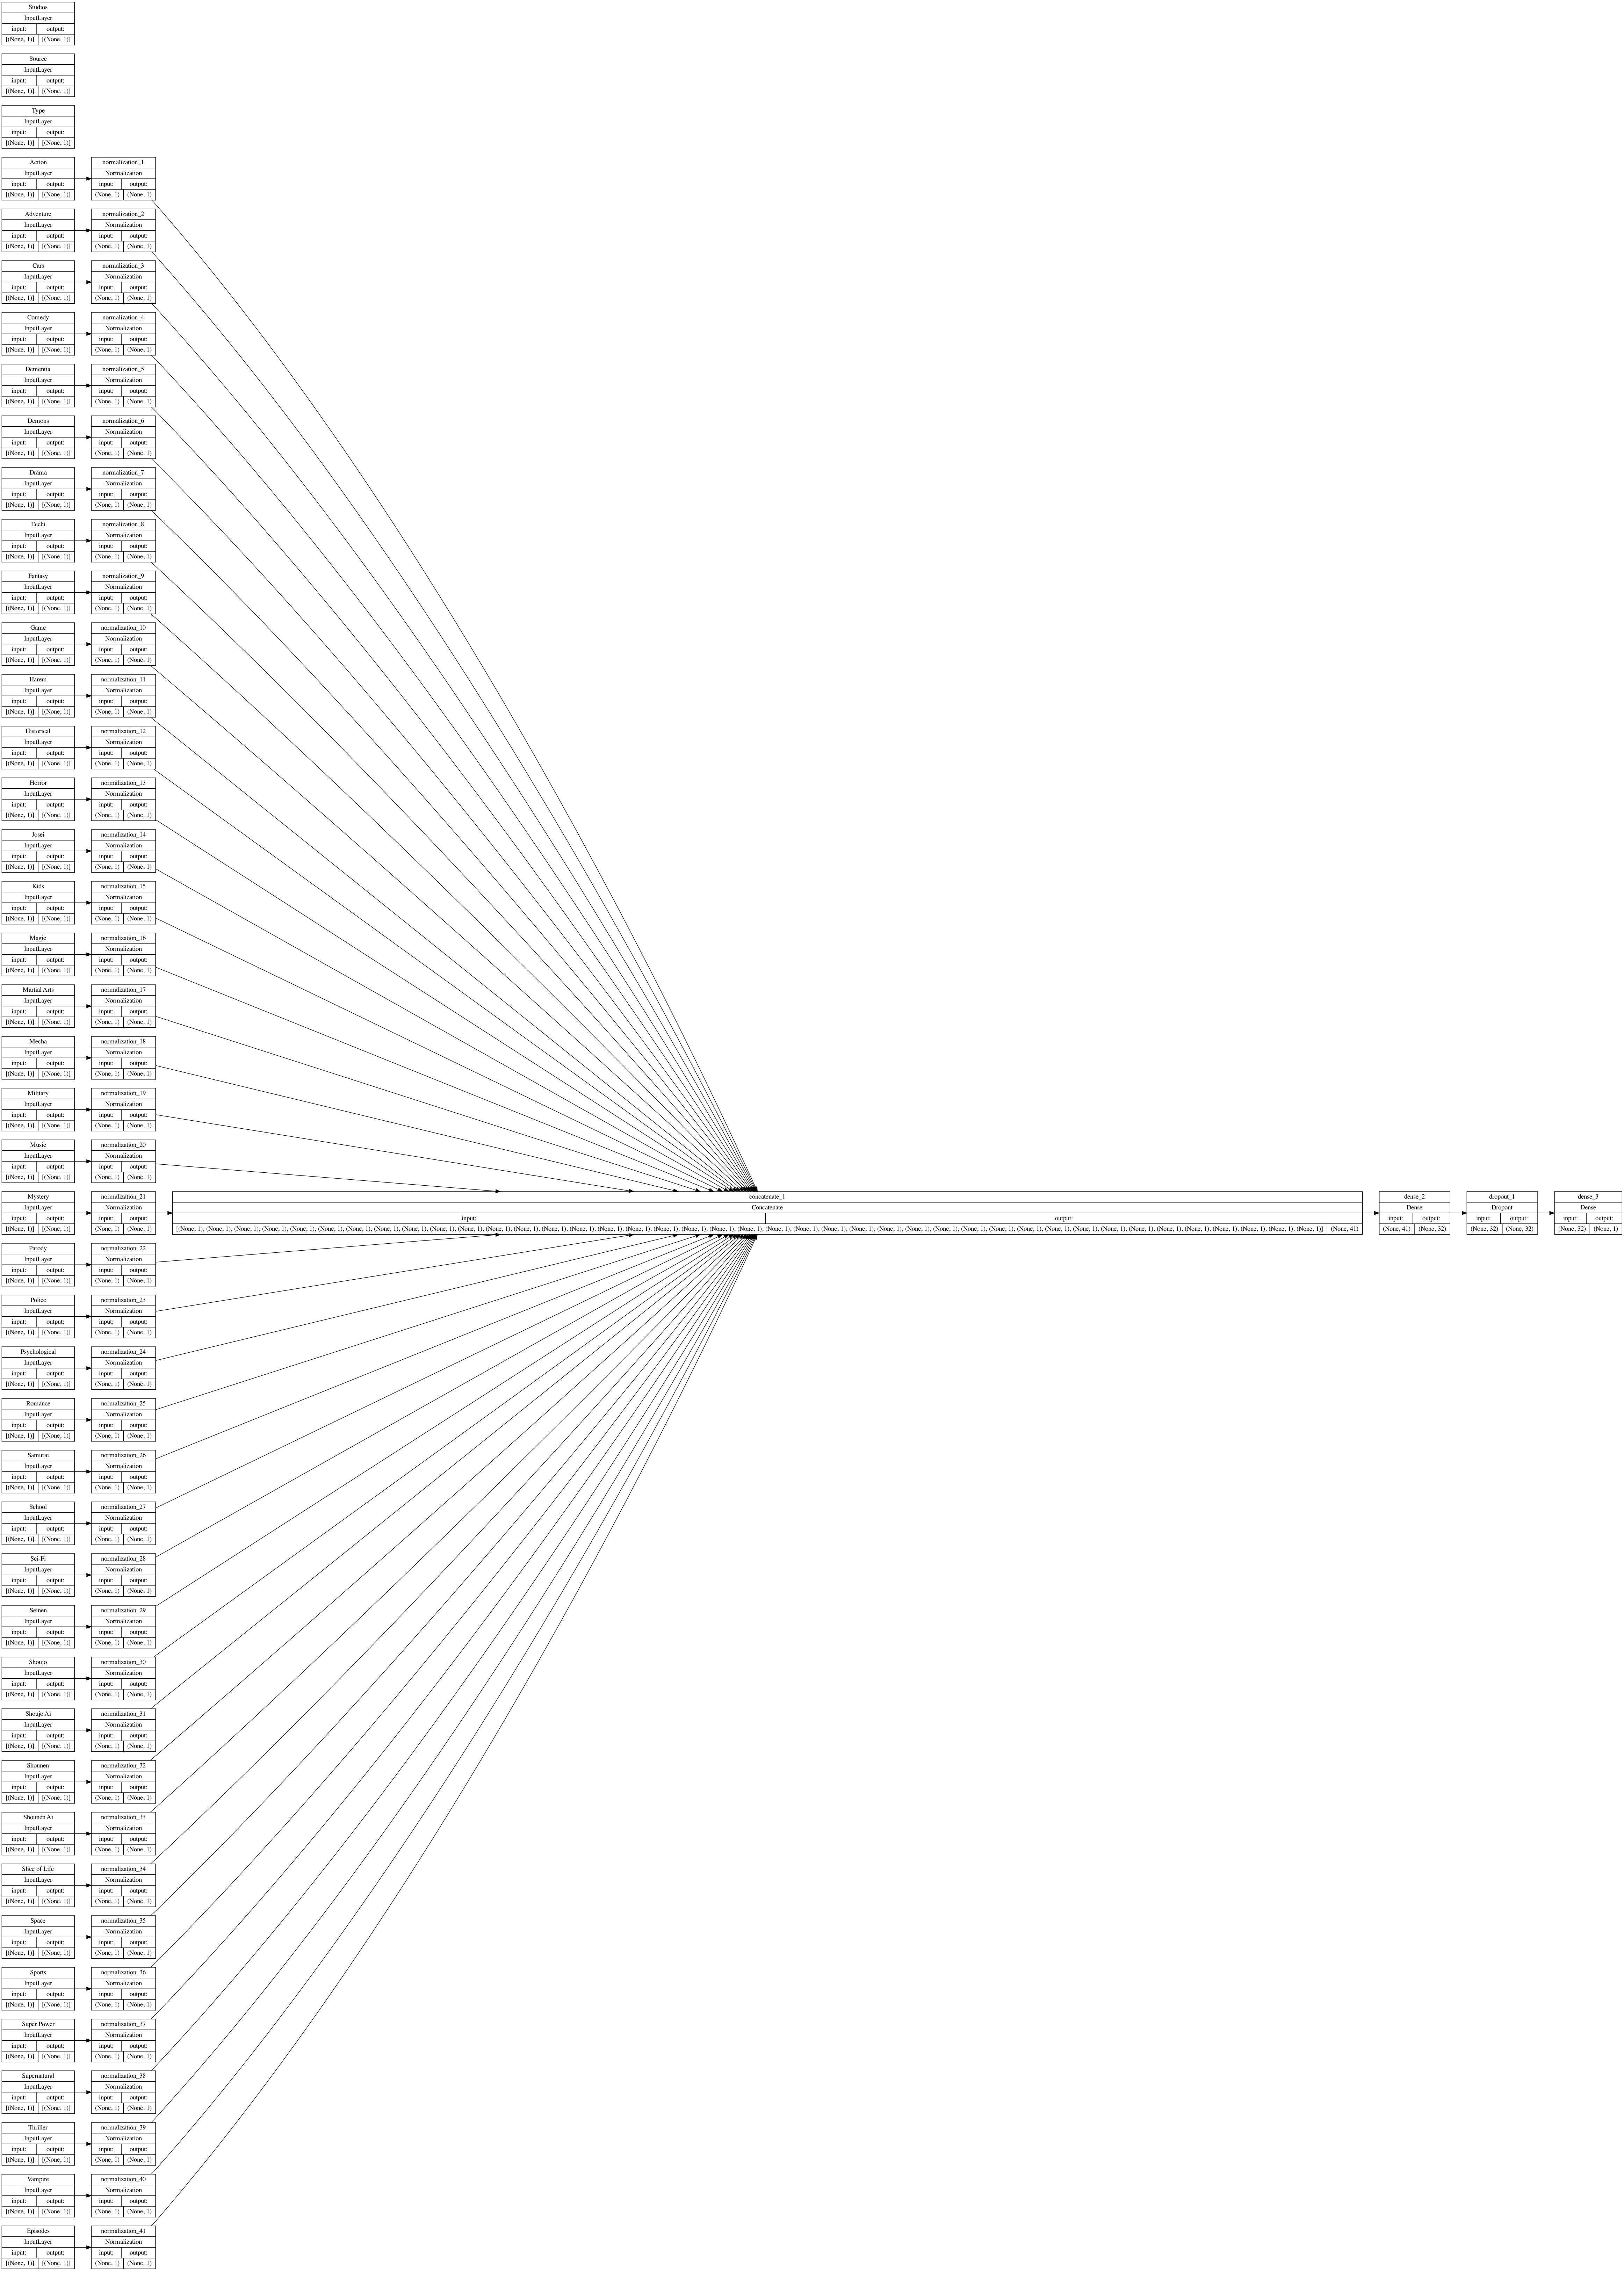

In [32]:
# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [33]:
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10


/opt/miniconda3/lib/python3.9/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['Score'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


35/35 [==============================] - 2s 24ms/step - loss: 6.1546 - accuracy: 0.0000e+00 - val_loss: 5.6160 - val_accuracy: 0.0000e+00
Epoch 2/10
35/35 [==============================] - 1s 9ms/step - loss: 5.1786 - accuracy: 0.0000e+00 - val_loss: 4.6070 - val_accuracy: 0.0000e+00
Epoch 3/10
35/35 [==============================] - 1s 9ms/step - loss: 4.2066 - accuracy: 0.0000e+00 - val_loss: 3.5840 - val_accuracy: 0.0000e+00
Epoch 4/10
35/35 [==============================] - 1s 9ms/step - loss: 3.3750 - accuracy: 0.0000e+00 - val_loss: 2.6569 - val_accuracy: 0.0000e+00
Epoch 5/10
35/35 [==============================] - 1s 10ms/step - loss: 2.7606 - accuracy: 0.0000e+00 - val_loss: 1.9385 - val_accuracy: 0.0000e+00
Epoch 6/10
35/35 [==============================] - 1s 10ms/step - loss: 2.3801 - accuracy: 0.0000e+00 - val_loss: 1.4524 - val_accuracy: 0.0000e+00
Epoch 7/10
35/35 [==============================] - 1s 9ms/step - loss: 2.2024 - accuracy: 0.0000e+00 - val_loss: 1.1873

In [34]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

5/5 [==============================] - 0s 9ms/step - loss: 1.0096 - accuracy: 0.0000e+00
Accuracy 0.0
